In [1]:
import gc
import itertools
import math
import os
import random
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Any, Callable, Literal, TypeAlias

import json
import random
from collections import defaultdict
from tqdm.auto import tqdm

import circuitsvis as cv
import einops
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
import torch as t
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from IPython.display import HTML, IFrame, clear_output, display
from jaxtyping import Float, Int
from openai import OpenAI
from rich import print as rprint
from rich.table import Table
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_vis import SaeVisConfig, SaeVisData, SaeVisLayoutConfig
from tabulate import tabulate
from torch import Tensor, nn
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import get_act_name, test_prompt, to_numpy

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

# from plotly_utils import imshow, line

MAIN = __name__ == "__main__"

In [4]:
USING_GEMMA = os.environ.get("HUGGINGFACE_KEY") is not None

if USING_GEMMA:
    !huggingface-cli login --token {os.environ["HUGGINGFACE_KEY"]}

    gemma_2_2b = HookedSAETransformer.from_pretrained("gemma-2-2b", device=device)

    gemmascope_sae_release = "gemma-scope-2b-pt-res-canonical"
    gemmascope_sae_id = "layer_20/width_16k/canonical"
    gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]
else:
    print("Please supply your Hugging Face API key before running this cell")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `nnsight` has been saved to C:\Users\maste\.cache\huggingface\stored_tokens
Your token has been saved to C:\Users\maste\.cache\huggingface\token
Login successful.
The current active token is: `nnsight`


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [5]:
gemmascope_sae_release = "gemma-scope-2b-pt-res-canonical"
gemmascope_sae_id = "layer_4/width_16k/canonical"
gemma_l5_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0] # l4 resid post l5 resid pre

In [6]:
def display_dashboard(
    sae_release="gemma-scope-2b-pt-res-canonical",
    sae_id="layer_4/width_16k/canonical",
    latent_idx=0,
    width=800,
    height=600,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))

CREATE DATA

In [6]:
def create_first_letter_examples(
    model, target_letter="E", num_examples=5000, context_template=None
):
    """
    Create examples for first-letter identification task.

    Args:
        model: The transformer model
        target_letter: The letter we want tokens to start with
        num_examples: Number of examples to generate
        context_template: Template for in-context learning examples

    Returns:
        List of dictionaries containing examples and metadata
    """
    if context_template is None:
        context_template = [
            "tartan has the first letter: T",
            "mirth has the first letter: M",
        ]

    # Get all tokens from the vocabulary that start with the target letter
    target_letter_lower = target_letter.lower()
    e_tokens = []

    for i in tqdm(range(len(model.tokenizer))):
        # Get the token string
        token_str = model.tokenizer.decode([i]).strip()

        # Check if the token starts with the target letter (case insensitive)
        if token_str and (token_str[0].lower() == target_letter_lower):
            # Store tokens with their IDs
            e_tokens.append({"token": token_str, "token_id": i})

    print(f"Found {len(e_tokens)} tokens starting with '{target_letter}' (case insensitive)")

    # If we don't have enough tokens, we'll sample with replacement
    if len(e_tokens) < num_examples:
        sampled_tokens = random.choices(e_tokens, k=num_examples)
    else:
        sampled_tokens = random.sample(e_tokens, num_examples)

    # Create the examples
    examples = []
    for token_info in sampled_tokens:
        token = token_info["token"]
        token_id = token_info["token_id"]

        # Create the prompt
        context_text = "\n".join(context_template)
        prompt = f"{context_text}\n{token} has the first letter:"

        # Store example info
        example = {
            "token": token,
            "token_id": token_id,
            "prompt": prompt,
            "expected_output": ' ' + target_letter,
            "context_template": context_template,
        }
        examples.append(example)

    return examples


def save_dataset(examples, filename="e_first_letter_dataset.json"):
    """Save the dataset to a JSON file"""
    with open(filename, "w") as f:
        json.dump(examples, f, indent=2)
    print(f"Dataset saved to {filename}")


def load_dataset(filename="e_first_letter_dataset.json"):
    """Load the dataset from a JSON file"""
    with open(filename, "r") as f:
        examples = json.load(f)
    print(f"Loaded {len(examples)} examples from {filename}")
    return examples

In [7]:
context_template = ["tartan has the first letter: T", "mirth has the first letter: M"]

e_examples = create_first_letter_examples(
    model=gemma_2_2b,
    target_letter="E",
    num_examples=5000,
    context_template=context_template,
)

  0%|          | 0/256000 [00:00<?, ?it/s]

Found 8832 tokens starting with 'E' (case insensitive)


ATTRIBUTION PATCHING

In [7]:
class SparseTensor:
    """
    Handles 2D tensor data (assumed to be non-negative) in 2 different formats:
        dense:  The full tensor, which contains zeros. Shape is (n1, ..., nk).
        sparse: A tuple of nonzero values (shape (n_nonzero,)), nonzero indices (shape (n_nonzero, k)), and the shape of
                the dense tensor.
    """

    sparse: tuple[Tensor, Tensor, tuple[int, ...]]
    dense: Tensor

    def __init__(self, sparse: tuple[Tensor, Tensor, tuple[int, ...]], dense: Tensor):
        self.sparse = sparse
        self.dense = dense

    @classmethod
    def from_dense(cls, dense: Tensor) -> "SparseTensor":
        sparse = (dense[dense > 0], t.argwhere(dense > 0), tuple(dense.shape))
        return cls(sparse, dense)

    @classmethod
    def from_sparse(
        cls, sparse: tuple[Tensor, Tensor, tuple[int, ...]]
    ) -> "SparseTensor":
        nonzero_values, nonzero_indices, shape = sparse
        dense = t.zeros(shape, dtype=nonzero_values.dtype, device=nonzero_values.device)
        dense[nonzero_indices.unbind(-1)] = nonzero_values
        return cls(sparse, dense)

    @property
    def values(self) -> Tensor:
        return self.sparse[0].squeeze()

    @property
    def indices(self) -> Tensor:
        return self.sparse[1].squeeze()

    @property
    def shape(self) -> tuple[int, ...]:
        return self.sparse[2]

In [8]:
def latent_acts_to_metric(
    latent_acts_nonzero: Float[Tensor, "nonzero_acts"],
    latent_acts_nonzero_inds: Int[Tensor, "nonzero_acts n_indices"],
    latent_acts_shape: tuple[int, ...],
    sae: SAE,
    model: HookedSAETransformer,
    sae_error_term,
) -> tuple[Tensor, tuple[Tensor]]:
    """
    
    """
    latent_acts = SparseTensor.from_sparse(
        (latent_acts_nonzero, latent_acts_nonzero_inds, latent_acts_shape)
    )
    res_stream = (
        sae.decode(latent_acts.dense) + sae_error_term
    ) 
    # layer 4 resid post, res_stream is layer 5 resid pre, so we should start at layer 5 = sae.cfg.hook_layer + 1
    logits = model(res_stream, start_at_layer=sae.cfg.hook_layer + 1)[0, -1]  # [d_vocab]
    difference = (
        logits[model.to_tokens(" E", prepend_bos=False).item()]
        - logits[model.to_tokens(" A B C D F G H I J K L M N O P Q R S T U V W X Y Z", prepend_bos=False)].mean()
    )
    return difference


def latent_attributions(
    tokens: Float[Tensor, "batch seq"],
    sae: SAE,
    model: HookedSAETransformer,
    k: int | None = None,
) -> tuple[Tensor, Tensor, Tensor, list[int] | None, SparseTensor]:
    """
    Computes the gradients between active latents and some top-k set of logits (we
    use k to avoid having to compute the gradients for all tokens).

    Returns:
        latent_logit_gradients:  The gradients between the SAE's active latents & downstream logits
        logits:                  The model's true logits
        logits_recon:            The model's reconstructed logits (i.e. based on SAE reconstruction)
        token_ids:               The tokens we computed the gradients for
        latent_acts:             The SAE's latent activations
    """
    assert tokens.shape[0] == 1, "Only supports batch size 1 for now"

    acts_hook_name = f"{sae.cfg.hook_name}.hook_sae_acts_post"
    sae_error_name = f"{sae.cfg.hook_name}.hook_sae_error"
    sae.use_error_term = True
    with t.no_grad():
        logits, cache = model.run_with_cache_with_saes(
            tokens,
            names_filter=[acts_hook_name, sae_error_name],
            saes=[sae],
            remove_batch_dim=False,
        )

    latent_acts = cache[acts_hook_name]
    latent_acts = SparseTensor.from_dense(latent_acts)
    sae_error_term = cache[sae_error_name]

    latent_logit_gradients = t.func.jacrev(latent_acts_to_metric)(
        *latent_acts.sparse,
        sae,
        model,
        sae_error_term,
    )

    latent_logit_attributions = latent_logit_gradients * latent_acts.sparse[0]
    sae.use_error_term = False

    return (
        latent_logit_gradients,
        latent_acts,
        latent_logit_attributions,
    )

In [10]:
e_examples[20]

{'token': 'extrait',
 'token_id': 186806,
 'prompt': 'tartan has the first letter: T\nmirth has the first letter: M\nextrait has the first letter:',
 'expected_output': ' E',
 'context_template': ['tartan has the first letter: T',
  'mirth has the first letter: M']}

COMPUTE ATTRIBUTIONS

In [ ]:
acts_and_attributions = []
for example in tqdm(e_examples):
    tokens = gemma_2_2b.to_tokens(example["prompt"], prepend_bos=True)
    (
        _,
        latent_acts,
        latent_logit_attributions,
    ) = latent_attributions(tokens, sae=gemma_l5_sae, model=gemma_2_2b)

    token_pos = 19
    position_mask = latent_acts.indices[:, 1] == token_pos
    filtered_indices = latent_acts.indices[position_mask].cpu().detach()
    filtered_attributions = latent_logit_attributions[position_mask].cpu().detach()
    filtered_activations = latent_acts.values[position_mask].cpu().detach()
    filtered_latent_acts = SparseTensor.from_sparse(
        (filtered_activations, filtered_indices, latent_acts.sparse[2])
    )

    acts_and_attributions.append(
        {"acts": filtered_latent_acts, "attributions": filtered_attributions}
    )

In [9]:
acts_and_attributions = t.load("acts_and_attributions.pt")

C:\Users\maste\AppData\Local\Temp\ipykernel_12156\1791053855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts_and_attributions = t.load("acts_and_attributions.pt")


ANALYSIS -- Compute L0 for acts and attributions

In [15]:
nonzero_attribution_rate = 0
for item in acts_and_attributions:
    acts = item["acts"]
    attributions = item["attributions"]
    nonzero_attribution_rate += attributions.shape[0] / gemma_l5_sae.cfg.d_sae

In [ ]:
nonzero_attribution_rate / len(e_examples)

In [13]:
acts_and_attributions[0]['acts'].values.shape[0]

382

In [11]:
acts_and_attributions[0]['attributions'].shape

torch.Size([382])

ANALYSIS -- find top latents by attribution

In [53]:
summed_attributions = t.zeros([16384])
for item in acts_and_attributions:
    acts = item["acts"]
    attributions = item["attributions"]
    latent_idx = acts.indices[..., 2]
    summed_attributions[latent_idx] += attributions

In [ ]:
mean_attributions = summed_attributions / len(e_examples)

In [65]:
mean_attr, latent_idx = t.topk(mean_attributions, k = 25)

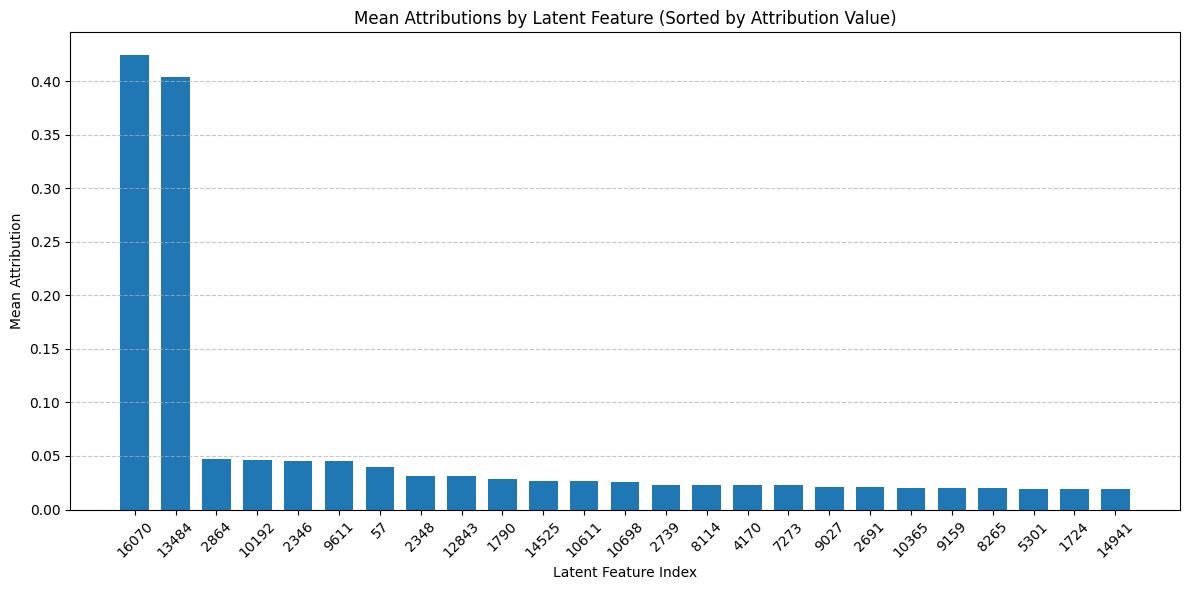

In [68]:
import matplotlib.pyplot as plt

# Sort the data by mean_attr values in descending order
sorted_indices = mean_attr.argsort(descending=True)
sorted_mean_attr = mean_attr[sorted_indices]
sorted_latent_idx = latent_idx[sorted_indices]

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_latent_idx)), sorted_mean_attr.numpy(), width=0.7)

# Set x-axis tick labels to be the actual latent indices
plt.xticks(range(len(sorted_latent_idx)), sorted_latent_idx.numpy(), rotation=45)

# Add labels and title
plt.xlabel('Latent Feature Index')
plt.ylabel('Mean Attribution')
plt.title('Mean Attributions by Latent Feature (Sorted by Attribution Value)')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()

-- Natural choice for SFC will be to only include latetn 16070 and 13484
-- Now we want to gather all instances where they are not most important

In [ ]:
summed_activations = t.zeros([16384])
for item in acts_and_attributions:
    acts = item["acts"]
    latent_idx = acts.indices[..., 2]
    summed_activations[latent_idx] += acts.values
mean_activations = summed_activations / len(e_examples)

In [116]:
mean_act, mean_act_idx = t.topk(mean_activations, k = 25)

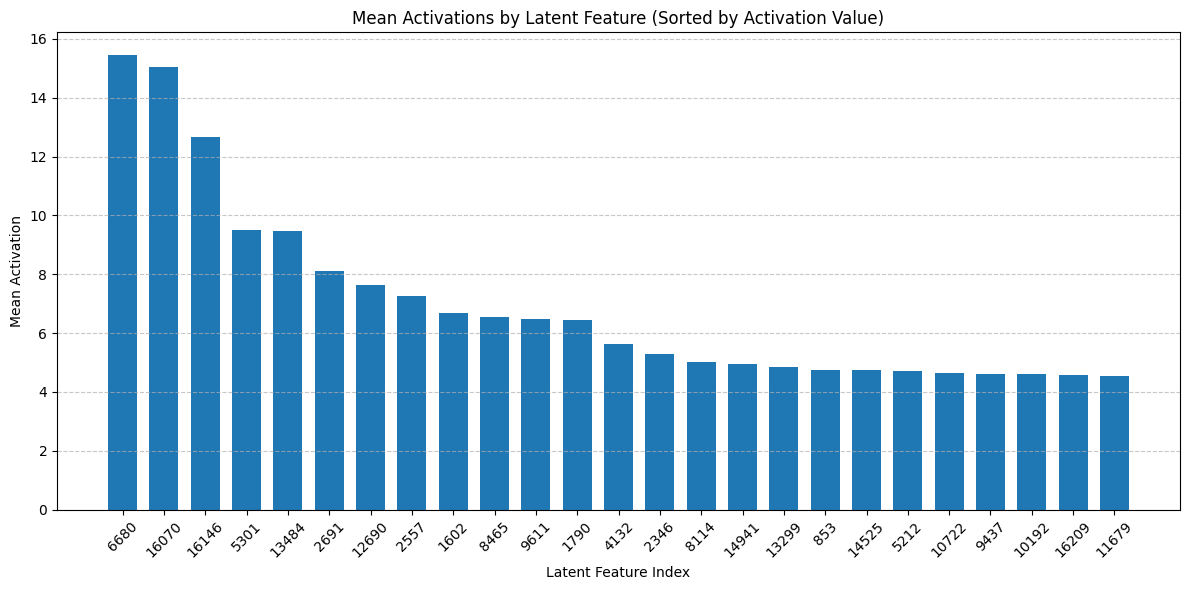

In [118]:
# Sort the data by mean_attr values in descending order
sorted_indices = mean_act.argsort(descending=True)
sorted_mean_act = mean_act[sorted_indices]
sorted_latent_idx = mean_act_idx[sorted_indices]

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_latent_idx)), sorted_mean_act.numpy(), width=0.7)

# Set x-axis tick labels to be the actual latent indices
plt.xticks(range(len(sorted_latent_idx)), sorted_latent_idx.numpy(), rotation=45)

# Add labels and title
plt.xlabel("Latent Feature Index")
plt.ylabel("Mean Activation")
plt.title("Mean Activations by Latent Feature (Sorted by Activation Value)")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Tight layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()

In [87]:
# find when neither 16070 nor 13484 are the top latent by attribution
# is checking top 2 best metric?

sfc_fails = t.zeros([5000])
for i, item in enumerate(acts_and_attributions):
    acts = item["acts"]
    attributions = item["attributions"]
    top_1_attrs, top_1_idx = t.topk(attributions, k = 1)
    latent_idx = acts.indices[..., 2]
    top_1 = latent_idx[top_1_idx]
    if not(13484 in top_1 or 16070 in top_1):
        sfc_fails[i] = 1 

In [ ]:
t.sum(sfc_fails) # SFC fails ~20% of the ti me

tensor(1102.)

In [ ]:
failed_examples = t.where(sfc_fails == 1)[0]

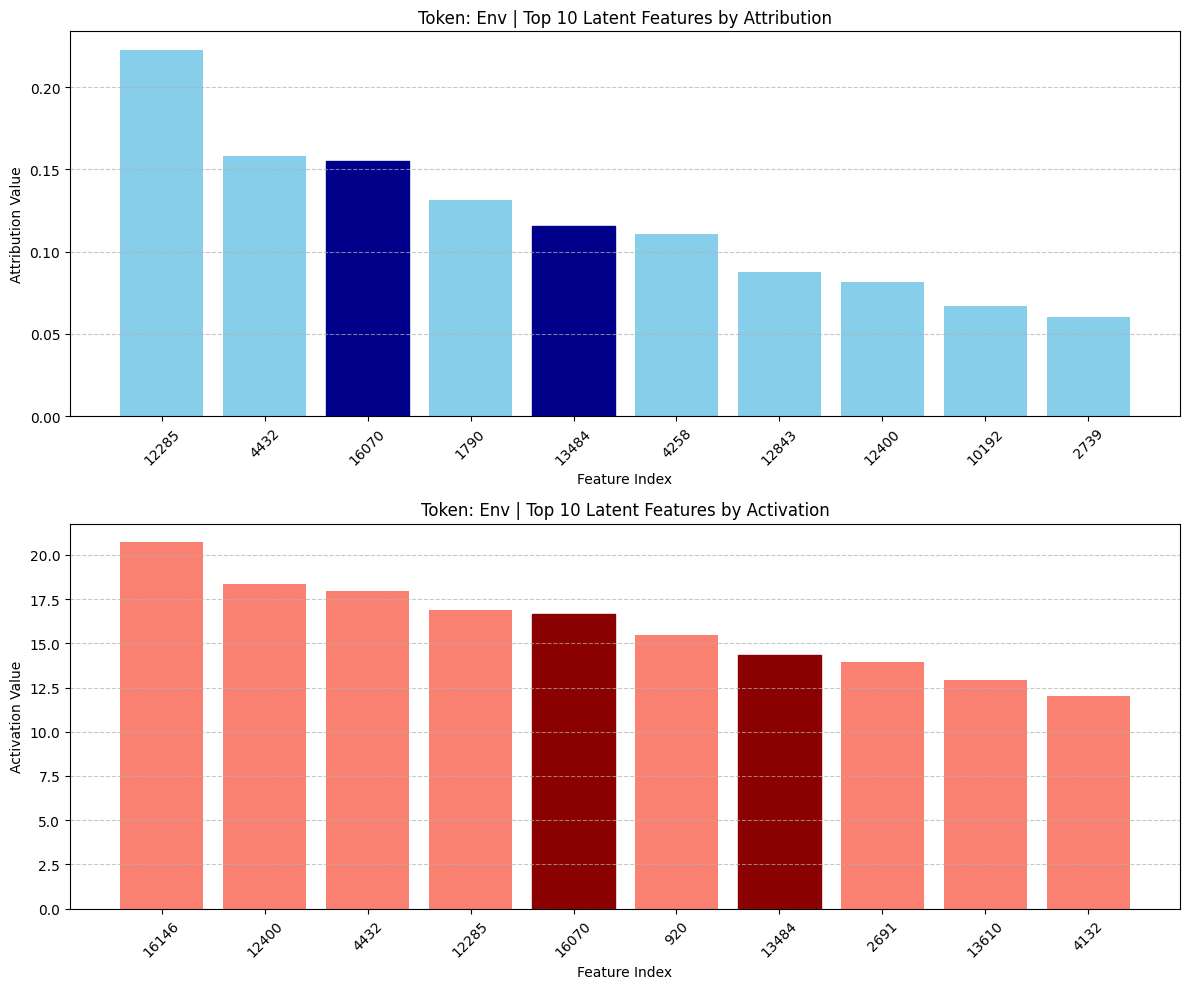

Example 176 - SFC failure: True
Token: Env


In [177]:
import pandas as pd
import matplotlib.pyplot as plt

# Get example data for a specific example
example_idx = failed_examples[34].item()  # Let's pick a different example for variety
example = acts_and_attributions[example_idx]
acts = example['acts']
attributions = example['attributions']

# Extract indices of features, latent indices, and values
latent_indices = acts.indices[:, 2]
activation_values = acts.values

# Create dataframe for easier sorting and visualization
feature_data = pd.DataFrame({
    'latent_idx': latent_indices.numpy(),
    'attributions': attributions.numpy(),
    'activations': activation_values.numpy()
})

# Sort by attributions (descending) to find most important features
attribution_sorted = feature_data.sort_values('attributions', ascending=False).reset_index(drop=True)
top_k = 10
top_by_attribution = attribution_sorted.head(top_k)

# Sort by activations (descending) to find most active features
activation_sorted = feature_data.sort_values('activations', ascending=False).reset_index(drop=True)
top_by_activation = activation_sorted.head(top_k)

# Create figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 10))

# Plot top features by attribution
bars1 = ax1.bar(range(top_k), top_by_attribution['attributions'], color='skyblue')
ax1.set_title(f"Token: {e_examples[example_idx]['token']} | Top 10 Latent Features by Attribution")
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Attribution Value')
ax1.set_xticks(range(top_k))
ax1.set_xticklabels([f'{idx}' for idx in top_by_attribution['latent_idx']], rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot top features by activation
bars3 = ax3.bar(range(top_k), top_by_activation['activations'], color='salmon')
ax3.set_title(f"Token: {e_examples[example_idx]['token']} | Top 10 Latent Features by Activation")
ax3.set_xlabel('Feature Index')
ax3.set_ylabel('Activation Value')
ax3.set_xticks(range(top_k))
ax3.set_xticklabels([f'{idx}' for idx in top_by_activation['latent_idx']], rotation=45)
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight "important" features (16070 and 13484) from our earlier analysis
for ax in [ax1, ax3]:
    for i, idx in enumerate(ax.get_xticklabels()):
        label = idx.get_text()
        if label in ['16070', '13484']:
            if ax == ax1:
                bars1[i].set_color('darkblue')
            else:
                bars3[i].set_color('darkred')

plt.tight_layout()
plt.show()

# Let's also print whether this is a "failure" case for our SFC
is_failure = bool(sfc_fails[example_idx].item())
print(f"Example {example_idx} - SFC failure: {is_failure}")
print(f"Token: {e_examples[example_idx]['token']}")


In [134]:
failed_examples

tensor([   0,   11,   13,  ..., 4988, 4993, 4999])

KEY RESULT -- Absorption rate

In [159]:
absorption_count = 0
for example in failed_examples.tolist():
    acts = acts_and_attributions[example]["acts"]
    attributions = acts_and_attributions[example]["attributions"]
    top_1_attrs, top_1_idx = t.topk(attributions, k = 1)
    latent_idx = acts.indices[..., 2]
    top_1 = latent_idx[top_1_idx]
    sim_16070 = F.cosine_similarity(gemma_l5_sae.W_dec[16070].unsqueeze(0), gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0))
    sim_13484 = F.cosine_similarity(gemma_l5_sae.W_dec[13484].unsqueeze(0), gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0))
    cosine_sim = max(sim_16070, sim_13484)
    if cosine_sim > 0.025:
        absorption_count += 1

absorption_rate = absorption_count / len(failed_examples) # of the failed examples, what pct due to absorption

In [ ]:
### KEY RESULT ###
absorption_rate

0.06261343012704174

LLM graphing spam:

In [179]:
main_features = [16070, 13484]
failed_examples = t.where(sfc_fails == 1)[0]
absorption_count = 0
for example in failed_examples.tolist():
    acts = acts_and_attributions[example]["acts"]
    attributions = acts_and_attributions[example]["attributions"]
    top_1_attrs, top_1_idx = t.topk(attributions, k=1)
    latent_idx = acts.indices[..., 2]
    top_1 = latent_idx[top_1_idx]

    # Calculate cosine similarity with main features
    sim_16070 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[0]].unsqueeze(0),
        gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0),
    )
    sim_13484 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[1]].unsqueeze(0),
        gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0),
    )
    cosine_sim = max(sim_16070.item(), sim_13484.item())

    if cosine_sim > 0.025:
        absorption_count += 1

absorption_rate = absorption_count / len(failed_examples)
print(f"Feature absorption rate: {absorption_rate:.2%}")

# %% Calculate baseline cosine similarity
print("Calculating baseline cosine similarity...")
cosine_sims = []
for i in range(gemma_l5_sae.W_dec.shape[0]):
    sim_16070 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[0]].unsqueeze(0),
        gemma_l5_sae.W_dec[i].unsqueeze(0),
    )
    sim_13484 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[1]].unsqueeze(0),
        gemma_l5_sae.W_dec[i].unsqueeze(0),
    )
    cosine_sim = max(sim_16070.item(), sim_13484.item())
    cosine_sims.append(cosine_sim)

cosine_sims_values = [sim for sim in cosine_sims]
above_threshold = sum(1 for sim in cosine_sims_values if sim > 0.025)
above_threshold_rate = above_threshold / len(cosine_sims_values)

Feature absorption rate: 6.26%
Calculating baseline cosine similarity...


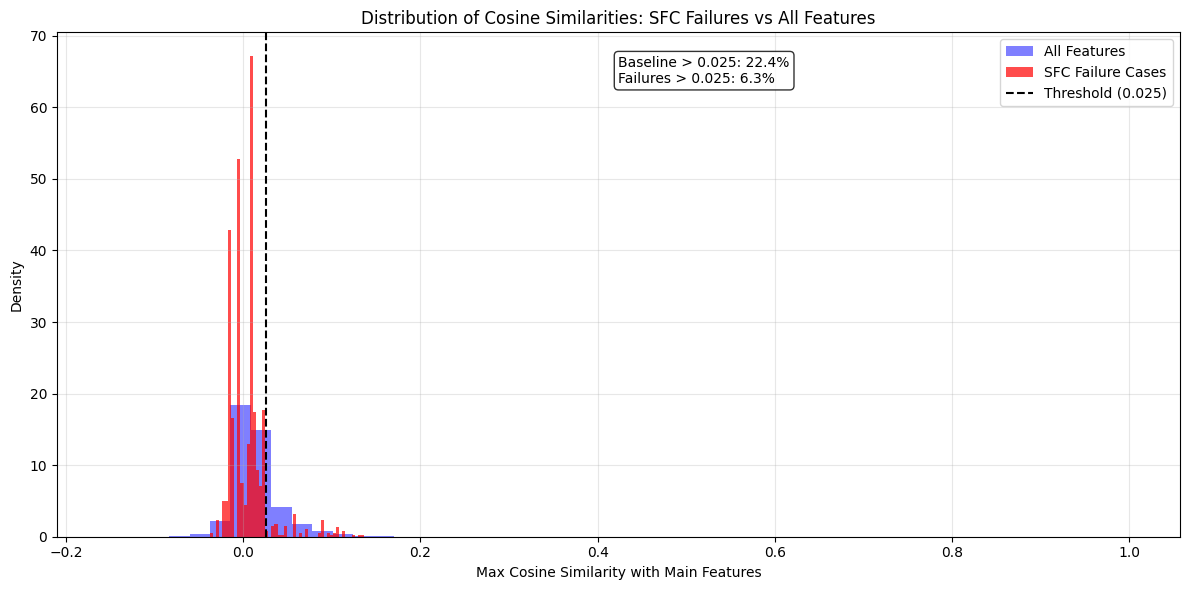

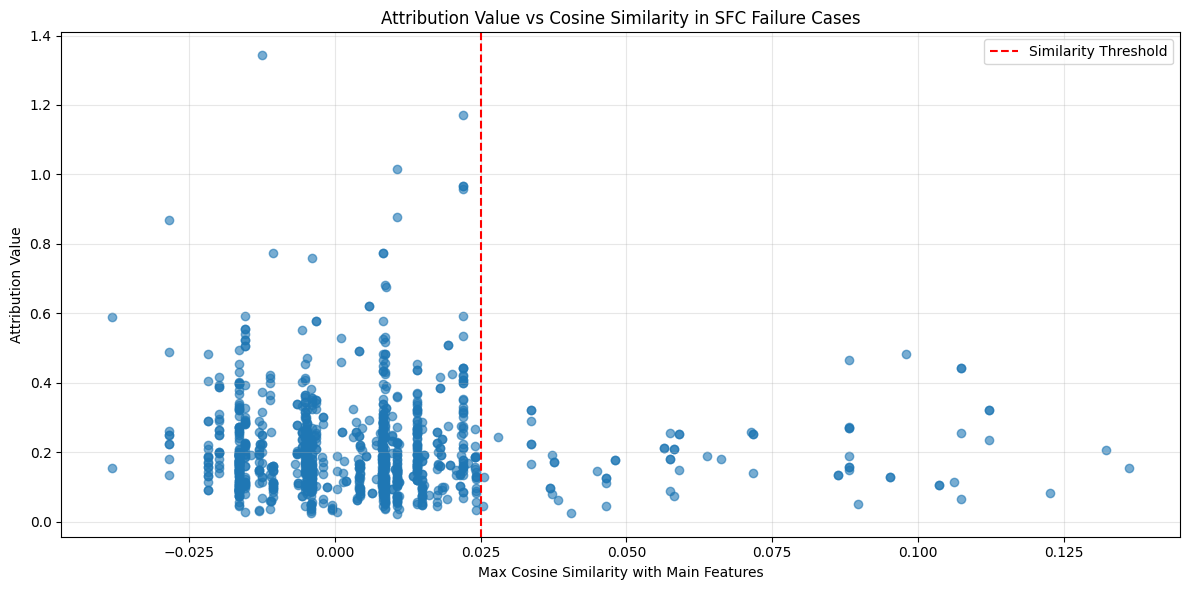

In [180]:
# %% Visualization of cosine similarities in failure cases
import matplotlib.pyplot as plt
import numpy as np

# Calculate cosine similarities for all failed examples
failed_examples = t.where(sfc_fails == 1)[0]
failed_cosine_sims = []

for example in failed_examples.tolist():
    acts = acts_and_attributions[example]["acts"]
    attributions = acts_and_attributions[example]["attributions"]
    top_1_attrs, top_1_idx = t.topk(attributions, k=1)
    latent_idx = acts.indices[..., 2]
    top_1 = latent_idx[top_1_idx]

    sim_16070 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[0]].unsqueeze(0),
        gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0),
    )
    sim_13484 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[1]].unsqueeze(0),
        gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0),
    )
    max_sim = max(sim_16070.item(), sim_13484.item())
    failed_cosine_sims.append(max_sim)

# %% Histogram of cosine similarities in failure cases vs baseline
plt.figure(figsize=(12, 6))

# Plot histogram of baseline similarities
plt.hist(
    cosine_sims_values,
    bins=50,
    alpha=0.5,
    label="All Features",
    color="blue",
    density=True,
)

# Plot histogram of failed examples similarities
plt.hist(
    failed_cosine_sims,
    bins=50,
    alpha=0.7,
    label="SFC Failure Cases",
    color="red",
    density=True,
)

# Add a vertical line at the threshold
plt.axvline(x=0.025, color="black", linestyle="--", label="Threshold (0.025)")

# Add labels and legend
plt.xlabel("Max Cosine Similarity with Main Features")
plt.ylabel("Density")
plt.title("Distribution of Cosine Similarities: SFC Failures vs All Features")
plt.legend()
plt.grid(alpha=0.3)

# Display statistics
plt.text(
    0.5,
    0.9,
    f"Baseline > 0.025: {above_threshold_rate:.1%}\nFailures > 0.025: {absorption_rate:.1%}",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

# %% Scatter plot of attribution value vs cosine similarity
plt.figure(figsize=(12, 6))

attribution_values = []
similarity_values = []

for example in failed_examples.tolist():
    acts = acts_and_attributions[example]["acts"]
    attributions = acts_and_attributions[example]["attributions"]
    top_1_attrs, top_1_idx = t.topk(attributions, k=1)
    latent_idx = acts.indices[..., 2]
    top_1 = latent_idx[top_1_idx]

    sim_16070 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[0]].unsqueeze(0),
        gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0),
    )
    sim_13484 = F.cosine_similarity(
        gemma_l5_sae.W_dec[main_features[1]].unsqueeze(0),
        gemma_l5_sae.W_dec[top_1.item()].unsqueeze(0),
    )
    max_sim = max(sim_16070.item(), sim_13484.item())

    attribution_values.append(top_1_attrs.item())
    similarity_values.append(max_sim)

plt.scatter(similarity_values, attribution_values, alpha=0.6)
plt.axvline(x=0.025, color="red", linestyle="--", label="Similarity Threshold")

plt.xlabel("Max Cosine Similarity with Main Features")
plt.ylabel("Attribution Value")
plt.title("Attribution Value vs Cosine Similarity in SFC Failure Cases")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

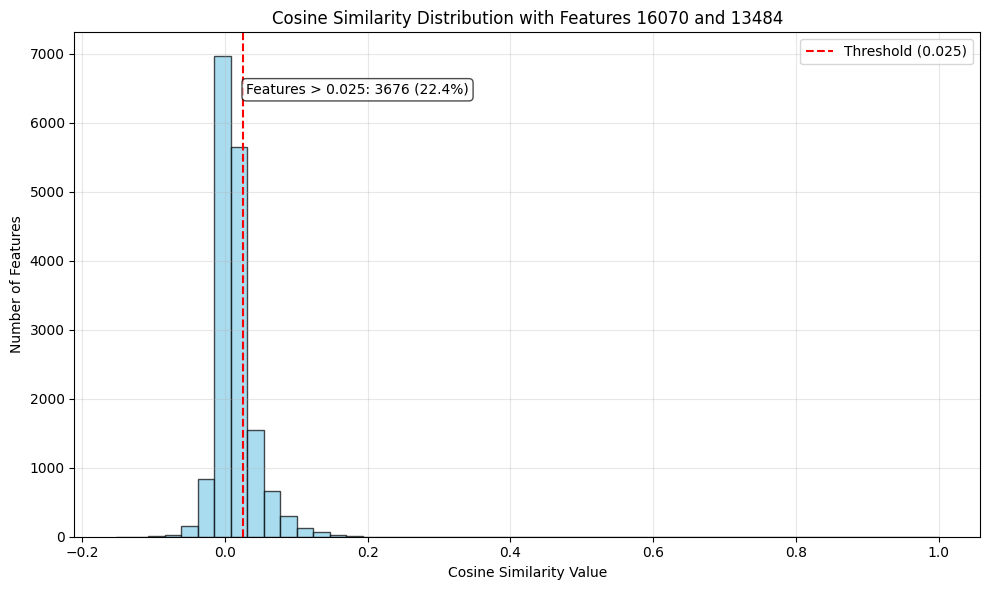

Total features: 16384
Mean similarity: 0.0145
Median similarity: 0.0090
Max similarity: 1.0000
Features with similarity > 0.025: 3676 (22.4%)


In [163]:
# Extract cosine similarities from the list
cosine_sims_values = [sim.item() for sim in cosine_sims]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(cosine_sims_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')

# Add vertical lines for common similarity thresholds
plt.axvline(x=0.025, color='red', linestyle='--', label='Threshold (0.025)')

# Highlight the frequency of features above threshold
above_threshold = np.sum(np.array(cosine_sims_values) > 0.025)
total_features = len(cosine_sims_values)
plt.text(0.03, plt.ylim()[1]*0.9, f"Features > 0.025: {above_threshold} ({above_threshold/total_features:.1%})", 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Add titles and labels
plt.title('Cosine Similarity Distribution with Features 16070 and 13484')
plt.xlabel('Cosine Similarity Value')
plt.ylabel('Number of Features')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

# Print some statistics
print(f"Total features: {len(cosine_sims_values)}")
print(f"Mean similarity: {np.mean(cosine_sims_values):.4f}")
print(f"Median similarity: {np.median(cosine_sims_values):.4f}")
print(f"Max similarity: {np.max(cosine_sims_values):.4f}")
print(f"Features with similarity > 0.025: {above_threshold} ({above_threshold/total_features:.1%})")

Checking if absorbing latents are token-aligned